# Affine Invariance Gradient Flows for Sampling

By choosing different energy functionals and metrics for the gradient flow, 
different algorithms with different convergence properties arise. 
In this work, we concentrate on the Kullback–Leibler divergence as the energy functional after showing that, up to scaling, it has the unique property (among all f-divergences) that the gradient flows resulting from this choice of energy do not depend on the normalization constant of the target distribution. For the metrics, we focus on variants of the Fisher-Rao, Wasserstein, and Stein metrics; we introduce the affine invariance property for gradient flows, and their corresponding mean-field models, determine whether a given metric leads to affine invariance, and modify it to make it affine invariant if it does not.
                

We study the resulting gradient flows in both the space of all probability density functions and in the subset of all Gaussian densities. The flow in the Gaussian space may be understood as a Gaussian approximation of the flow in the density space. We demonstrate that, under mild assumptions, the Gaussian approximation based on the metric and through moment closure coincide; the moment closure approach is more convenient for calculations. We establish connections between these approximate gradient flows, discuss their relation to natural gradient methods in parametric variational inference, and study their long-time convergence properties showing, for some classes of problems and metrics, the advantages of affine invariance. Furthermore, numerical experiments are included which demonstrate that affine invariant gradient flows have desirable convergence properties for a wide range of highly anisotropic target distributions.


In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/NGD.jl")
include("../Inversion/IPS.jl")
include("../Inversion/Utility.jl")

cos_error_estimation_particle (generic function with 3 methods)

## Overview of algorithms
We study following gradient flows in the space of probability measures for sampling 
* Wasserstein gradient flow 
* Affine invariant Wasserstein gradient flow 
* Stein gradient flow 
* Affine invariant Stein gradient flow 
    
We study following Gaussian approximate gradient flows in the space of probability measures for sampling 
* Gaussian approximate gradient flow (regular gradient descent) 
* Gaussian approximate Fisher-Rao gradient flow  
* Gaussian approximate Wasserstein gradient flow  


## Overview of test cases

We focus our experiments for sampling $e^{-\Phi_R(\theta)}$ on three two-dimensional  posteriors. In defining
them we use the notation $\theta = [\theta^{(1)},\theta^{(2)}]^T$.
* Gaussian posterior     

$$
    \Phi_R(\theta) = \frac{1}{2}\theta^{T}
    \begin{bmatrix}
      1 & 0\\
      0 & \lambda
    \end{bmatrix}
    \theta
    \quad \textrm{with} \quad \lambda = 0.01,\,0.1,\,1.
$$
    
    We initialize the gradient flows from 
    
$$
    \theta_0 \sim \mathcal{N}\Bigl(
    \begin{bmatrix}
  10\\
  10
    \end{bmatrix}
, 
\begin{bmatrix}
  \frac{1}{2} & 0\\
  0 & 2
\end{bmatrix}\Bigr).
$$

* Logconcave posterior
    
$$
\Phi_R(\theta) = \frac{(\sqrt{\lambda}\theta^{(1)} - \theta^{(2)})^2}{20} +\frac{(\theta^{(2)})^4}{20} \quad \textrm{with} \quad \lambda = 0.01,\,0.1,\,1.
$$

    We initialize the gradient flows from 
$
\theta_0 \sim \mathcal{N}\Bigl(
\begin{bmatrix}
  10\\
  10
\end{bmatrix}
, 
\begin{bmatrix}
  4 & 0\\
  0 & 4
\end{bmatrix}\Bigr)
$.


* General posterior

$$
\Phi_R(\theta) = \frac{\lambda( \theta^{(2)} - (\theta^{(1)})^2)^2}{20} + \frac{(1 - \theta^{(1)})^2}{20}  \quad \textrm{with} \quad \lambda = 0.01,\,0.1,\,1.
$$
    This example is known as the Rosenbrock function. We initialize the gradient flows from 
$$
\theta_0 \sim \mathcal{N}\Bigl(
\begin{bmatrix}
  0\\
  0
\end{bmatrix}
, 
\begin{bmatrix}
  4 & 0\\
  0 & 4
\end{bmatrix}\Bigr).
$$


The summary statistics that we use to compare the resulting solution with the ground truth are the expectation $\mathbb{E}[\theta]$, the covariance $Cov[\theta]$, and $\mathbb{E}[\cos(\omega^T \theta + b)]$; in the latter case we randomly draw $\omega\sim\mathcal{N}(0, I)$ and $b\sim \textrm{Uniform}(0, 2\pi)$ and report the average MSE over 20 random draws of $\omega$ and $b$. The ground truths of these summary statistics are evaluated by integrating $\rho_{\rm post}$ numerically. 



In [16]:
mutable struct Setup_Param{IT<:Int, VEC, MAT}
    N_θ::IT
    m_oo::VEC
    C_oo::MAT
end

function log_concave(θ,  λ)
    θ₁, θ₂ = θ
    return -( (sqrt(λ)*θ₁ - θ₂)^2 + θ₂^4)/20
end


function Logconvave_compute_Eref(λ, ω, b)
    # analytical solution
    yy = Array(LinRange(-200.0, 200.0, 10^7))

    E1 = sum(exp.(-yy.^4/20))
    Eθ₁²  = sum((yy.^2 .+ 10).* exp.(-yy.^4/20))/λ  / E1
    Eθ₁θ₂ = sum(yy.^2 .* exp.(-yy.^4/20))/sqrt(λ)   /E1
    Eθ₂²  = sum(yy.^2 .* exp.(-yy.^4/20))     /E1
    Ecos = zeros(length(b))
    for i = 1:length(b)
        Ecos[i]  = sum(cos.((ω[i,1]/sqrt(λ) + ω[i,2])*yy .+ b[i]).* exp.(-yy.^4/20))/exp(5/λ*ω[i,1]^2) /E1
    end
    return [0;0], [Eθ₁² Eθ₁θ₂; Eθ₁θ₂ Eθ₂²], Ecos 
end



function log_Rosenbrock(θ,  λ)
    θ₁, θ₂ = θ
    return -λ*(θ₂ - θ₁^2)^2/20 - (1.0 - θ₁)^2/20  #+ log_prior(θ)
end

function Rosenbrock_compute_Eref(λ, ω, b)
    xx = Array(LinRange(-200.0, 200.0, 10^7))

    E1 = sum(exp.(-(1 .- xx).^2/20))
    Eθ₁²  = sum(xx.^2 .* exp.(-(1 .- xx).^2/20))  / E1
    Eθ₁θ₂ = sum(xx.^3 .* exp.(-(1 .- xx).^2/20))  /E1
    Eθ₂²  = sum((xx.^4 .+ 10/λ) .* exp.(-(1 .- xx).^2/20))     /E1
    Ecos = zeros(length(b))
    for i = 1:length(b)
        Ecos[i]  = sum(cos.(ω[i,2]*xx.^2 + ω[i,1]*xx .+ b[i]).* exp.(-(1 .- xx).^2/20))/exp(5/λ*ω[i,2]^2) /E1
    end

    return [1.0;11.0], [Eθ₁²-1.0 Eθ₁θ₂-11.0; Eθ₁θ₂-11.0 Eθ₂²-121.0], Ecos 
end


function Gaussian_2d(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}; std=2,  N_p = 100) where {FT<:AbstractFloat}
    
    N_p = 100
    std = 2
    U, S, _ = svd(θθ_cov)
    xy_p  = [cos.(LinRange(0, 2*pi, N_p))  sin.(LinRange(0, 2*pi, N_p))]'

    xy_p = U * (std * sqrt.(S) .* xy_p) + θ_mean*ones(N_p)'

    return xy_p[1, :], xy_p[2, :]
end


function KL_estimator(m, C, func_log_rho_post; N_ens = 100)
    Random.seed!(42)
    
    N_θ = length(m)
    c_weights    =  rand(Normal(0, 1), N_θ, N_ens)
    # shift mean to and covariance to I
    c_weights -= dropdims(mean(c_weights, dims=2), dims=2)*ones(N_ens)'
    U1, S1, _ = svd(c_weights)
    c_weights = (S1/sqrt(N_ens - 1.0) .\U1') *  c_weights 

    chol_C = cholesky(Hermitian(C)).L
    xs = zeros(N_ens, N_θ)
    xs .= (m * ones(N_ens)' + chol_C * c_weights)'
    
    log_rho_posts = zeros(N_ens)
    for i = 1:N_ens
        log_rho_posts[i] = func_log_rho_post(xs[i,:])
    end
    return -1/2*log(det(C)) - sum(log_rho_posts)/N_ens
end

function gradient_flow_for_sampling(problem_type, m_0, C_0; λs = [0.01, 0.1, 1], N_ens = 100, Δt = 0.001, N_t = 15000)
    fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))
    fig_cont, ax_cont = PyPlot.subplots(ncols=3, nrows=4, sharex="col", sharey=false, figsize=(12,12))

    
    ts = LinRange(0, Δt*N_t, N_t+1)
    θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')
    ω =  rand(Normal(0, 1), (20, 2))
    b = rand(Uniform(0, 2*pi), 20)

    for test_id = 1:length(λs)
        λ = λs[test_id]
        if problem_type == "Gaussian"
            
            m_oo = [0.0; 0.0]
            C_oo = [1.0 0.0; 0.0 1/λ]
            cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 
            logρ = θ->-0.5*θ'*(C_oo\θ)
            x_min, x_max = -3, 3
            y_min, y_max = -3/sqrt(λ), 3/sqrt(λ)
            
        elseif problem_type == "Logconcave"
                
            logρ = θ->log_concave(θ,  λ)
            m_oo, C_oo, cos_ref  = Logconvave_compute_Eref(λ, ω, b)
            x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
            x_min, x_max = x_ranges[test_id]
            y_min, y_max = -3, 3
         
        elseif problem_type == "Rosenbrock" 
                    
            logρ= θ->log_Rosenbrock(θ,  λ)
            m_oo, C_oo, cos_ref = Rosenbrock_compute_Eref(λ, ω, b)
            x_min, x_max = -4.0, 6.0
            y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]
            y_min, y_max = y_ranges[test_id]
                    
        else
            error(problem_type*" has not implemented")        
        end
        

        
        # Contour plot
        s_param = Setup_Param(N_θ, m_oo, C_oo)
        function ∇logρ(s_param::Setup_Param, θ)
            return ForwardDiff.gradient(logρ, θ)
        end
        N_x, N_y = 1000, 1000
        xx_cont = Array(LinRange(x_min, x_max, N_x))
        yy_cont = Array(LinRange(y_min, y_max, N_y))
        X_cont,Y_cont = repeat(xx_cont, 1, N_y), repeat(yy_cont, 1, N_x)'
        Z_cont = zeros(N_x, N_y)
        for i = 1:N_x
            for j = 1:N_y
                Z_cont[i, j] = logρ( [X_cont[i,j], Y_cont[i,j]] )
            end
        end
        Z_cont .= exp.(Z_cont)
        for i = 1:4
            ax_cont[i, test_id].contour(X_cont, Y_cont, Z_cont, 5, colors="grey", alpha=0.5)
        end
        
        # Sampling plot 
        for method in ["Wasserstein", "Stein"]
            for preconditioner in [false, true]

                ips_obj = IPS_Run(s_param, ∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)

                ips_errors    = zeros(N_t+1, 3)
                for i = 1:N_t+1
                    m_i, C_i = dropdims(mean(ips_obj.θ[i], dims=1), dims=1), construct_cov(ips_obj, ips_obj.θ[i])
                    ips_errors[i, 1] = norm(m_i .- m_oo)
                    ips_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
                    ips_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
                end
                @info method, " preconditioner ", preconditioner, " λ = ", λ
                @info "mean = ", dropdims(mean(ips_obj.θ[end], dims=1), dims=1), " ", m_oo
                @info "cov = ", construct_cov(ips_obj, ips_obj.θ[end]), " ", C_oo
            


                ites = Array(0:N_t)
                markevery = div(N_t, 10)
                label, color, marker = "Fisher-Rao", "C2", "o"
                if (method  == "Wasserstein" || method  == "Stein")
                    label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                    color = (method  == "Stein" ? "C0" : "C1")
                    if method  ==  "Wasserstein" && ~preconditioner
                        color  = "C2"
                    end
                    if method  ==  "Stein" && ~preconditioner
                        color  = "C3"
                    end

                    marker = (method  == "Stein" ? "*" : "s")
                end
                linestyle = preconditioner ?  "solid" : "dotted"


                ax[1, test_id].semilogy(ts, ips_errors[:, 1], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
                ax[2, test_id].semilogy(ts, ips_errors[:, 2], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
                ax[3, test_id].semilogy(ts, ips_errors[:, 3], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)


                if (method == "Wasserstein" && ~preconditioner)
                    ax_cont[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                elseif (method == "Wasserstein" && preconditioner)
                    ax_cont[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                elseif (method == "Stein" && ~preconditioner)
                    ax_cont[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                else 
                    ax_cont[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                end

            end
        end

        ax_cont[1, test_id].set_title(L"\lambda = " * string(λ))            
        ax[1, test_id].set_title(L"\lambda = " * string(λ))
        ax[1, test_id].set_xlabel("t")
        ax[2, test_id].set_xlabel("t")
        ax[3, test_id].set_xlabel("t")

        ax[1, test_id].grid("on")
        ax[2, test_id].grid("on")
        ax[3, test_id].grid("on")

        ax_cont[4,test_id].set_xlabel(L"\theta^{(1)}")

    end

    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=4)
    ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
    ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
    ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")

    fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
    fig.savefig(problem_type*"_gd_particle_converge.pdf")


    ax_cont[1, 1].set_ylabel("Wasserstein GF")
    ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein  GF")
    ax_cont[3, 1].set_ylabel("Stein  GF")
    ax_cont[4, 1].set_ylabel("Affine invariant Stein  GF")
    fig_cont.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
    fig_cont.savefig(problem_type*"_gd_particle_contour.pdf")
end

gradient_flow_for_sampling (generic function with 1 method)

In [30]:
function Gaussian_approximated_gradient_flow_for_sampling(problem_type, m_0, C_0; λs = [0.01, 0.1, 1], Δt = 0.001, N_t = 15000, sampling_method = "UnscentedTransform", N_ens=100, compute_gradient = "second-order")
    # For general posterior functions
    fig_err, ax_err = PyPlot.subplots(ncols=length(λs), sharex=true, sharey=false, figsize=(12,4))
    fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(λs), sharex=false, sharey=false, figsize=(12,4))
    fig_converge, ax_converge = PyPlot.subplots(ncols=length(λs), sharex=true, sharey=true, figsize=(12,4))
    fig_conv, ax_conv = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))

    ω = rand(Normal(0, 1), (20, 2))
    b = rand(Uniform(0, 2*pi), 20)
    for test_id = 1:length(λs)
        
        λ = λs[test_id]
        if problem_type == "Logconcave"
                
            logρ = θ->log_concave(θ,  λ)
            m_oo, C_oo, cos_ref  = Logconvave_compute_Eref(λ, ω, b)
            x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
            x_min, x_max = x_ranges[test_id]
            y_min, y_max = -3, 3
            
        elseif problem_type == "Rosenbrock" 
                    
            logρ = θ->log_Rosenbrock(θ,  λ)
            m_oo, C_oo, cos_ref = Rosenbrock_compute_Eref(λ, ω, b)
            x_min, x_max = -4.0, 6.0
            y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]
            y_min, y_max = y_ranges[test_id]
                    
        else
            error(problem_type*" has not implemented")        
        end
        
        function compute_Φ(s_param, θ) 
            Φ =   -logρ(θ)
            dΦ =  -ForwardDiff.gradient(logρ, θ)
            ddΦ = -ForwardDiff.hessian(logρ, θ)
            return Φ, dΦ, ddΦ
        end

        N_x, N_y = 100, 100
        xx = Array(LinRange(x_min, x_max, N_x))
        yy = Array(LinRange(y_min, y_max, N_y))
        X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
        Z = zeros(N_x, N_y)
        for i = 1:N_x
            for j = 1:N_y
                Z[i, j] = logρ( [X[i,j], Y[i,j]] )
            end
        end
        Z .= exp.(Z)
        ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")


        N_θ = length(m_0)
        s_param = Setup_Param(N_θ, m_0, C_0)
        Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
        if sampling_method == "UnscentedTransform"
            N_ens = 2*N_θ+1
        end
        N_t_tot = 2*N_t


        
        gradient_flow = "Fisher-Rao"
        ngd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
        @info "finish ", gradient_flow

        gradient_flow = "Gradient_descent"
        gd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
        @info "finish ", gradient_flow

        gradient_flow = "Wasserstein"
        wgd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
        @info "finish ", gradient_flow

        N_t = div(N_t_tot, 2)
        N_p=100
        X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_t], gd_obj.θθ_cov[N_t]; std = 3, N_p=N_p)
        ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gaussian approximate GF")
        X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_t], wgd_obj.θθ_cov[N_t])
        ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Gaussian approximate Wasserstein GF")
        X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_t], ngd_obj.θθ_cov[N_t])
        ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Gaussian approximate Fisher-Rao GF")
        ax_scatter[test_id].set_title(L"\lambda = " * string(λs[test_id]))

        if test_id ==1
            ax_scatter[test_id].set_ylabel(L"\theta^{(2)}")
        end
        ax_scatter[test_id].set_xlabel(L"\theta^{(1)}")

        e_gd = zeros(N_t+1)
        e_wgd = zeros(N_t+1)
        e_ngd = zeros(N_t+1)
        for i = 1:N_t+1
            e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i], logρ)  
            e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], logρ)  
            e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], logρ)  
        end

        ts = Array(0:N_t) * Δt
        markevery = div(N_t,10)
        ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gradient descent")
        ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Wasserstein gradient descent")
        ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Natural gradient descent")
        ax_err[test_id].set_title(L"\lambda = " * string(λs[test_id]))

        if test_id ==1
            ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
        end

        ax_err[test_id].set_xlabel("t")
        ax_err[test_id].grid("on")


        ekl_gd, ekl_ngd, ekl_wgd = zeros(N_t+1),  zeros(N_t+1),  zeros(N_t+1)
        for i = 1:N_t+1


            m_end, C_end = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
            U,S,V = svd(C_end)
            C_end_sqrt = U*Diagonal(sqrt.(S))*V'
            U,S,V = svd(C_end_sqrt * ngd_obj.θθ_cov[i] * C_end_sqrt)
            ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_end)^2 + tr(ngd_obj.θθ_cov[i] + C_end - 2*U*Diagonal(sqrt.(S))*V') )

            m_end, C_end = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
            U,S,V = svd(C_end)
            C_end_sqrt = U*Diagonal(sqrt.(S))*V'
            U,S,V = svd(C_end_sqrt * gd_obj.θθ_cov[i] * C_end_sqrt)
            ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_end)^2 + tr(gd_obj.θθ_cov[i] + C_end - 2*U*Diagonal(sqrt.(S))*V') )


            m_end, C_end = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
            U,S,V = svd(C_end)
            C_end_sqrt = U*Diagonal(sqrt.(S))*V'
            U,S,V = svd(C_end_sqrt * wgd_obj.θθ_cov[i] * C_end_sqrt)
            ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_end)^2 + tr(wgd_obj.θθ_cov[i] + C_end - 2*U*Diagonal(sqrt.(S))*V') )
        end

        ekl_wgd ./= ekl_wgd[1]
        ekl_gd  ./= ekl_gd[1]
        ekl_ngd ./= ekl_ngd[1]

        ts = Array(0:N_t) * Δt
        markevery = div(N_t,10)
        ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gradient descent")
        ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Wasserstein gradient descent")
        ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Natural gradient descent")
        ax_converge[test_id].set_title(L"\lambda = " * string(λs[test_id]))    
        if test_id ==1
            ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
        end
        ax_converge[test_id].set_xlabel("t")
        ax_converge[test_id].grid("on")



        gd_errors    = zeros(N_t+1, 3)
        ngd_errors    = zeros(N_t+1, 3)
        wgd_errors    = zeros(N_t+1, 3)
        for i = 1:N_t+1
            m_i, C_i = gd_obj.θ_mean[i], gd_obj.θθ_cov[i]
            gd_errors[i, 1]  = norm(m_i .- m_oo)
            gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
            gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))

            m_i, C_i = ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i]
            ngd_errors[i, 1]  = norm(m_i .- m_oo)
            ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
            ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
            
            
            m_i, C_i = wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i]
            wgd_errors[i, 1]  = norm(m_i .- m_oo)
            wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
            wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
            
        end
        markevery=div(N_t, 10)
        ax_conv[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
        ax_conv[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
        ax_conv[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)

        ax_conv[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
        ax_conv[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
        ax_conv[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)

        ax_conv[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
        ax_conv[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
        ax_conv[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)

        ax_conv[1, test_id].set_title(L"\lambda = " * string(λs[test_id]))
        ax_conv[1, test_id].set_xlabel("t")
        ax_conv[2, test_id].set_xlabel("t")
        ax_conv[3, test_id].set_xlabel("t")

        ax_conv[1, test_id].grid("on")
        ax_conv[2, test_id].grid("on")
        ax_conv[3, test_id].grid("on")

    end
    handles, labels = ax_scatter[1,1].get_legend_handles_labels()
    fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=5)
    fig_scatter.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
    fig_scatter.savefig(problem_type*"_gd_contour.pdf")




    handles, labels = ax_conv[1,1].get_legend_handles_labels()
    fig_conv.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
    ax_conv[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
    ax_conv[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
    ax_conv[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
    fig_conv.subplots_adjust(bottom=0.05,top=0.89,left=0.1,right=0.98,hspace=0.2)
    fig_conv.savefig(problem_type*"_gd_converge.pdf")

end




Gaussian_approximated_gradient_flow_for_sampling (generic function with 1 method)

# Gaussian posterior

In [18]:
function residual(method_type::String, m_oo, C_oo, m, C)
    if method_type == "gradient_descent"
        return -C_oo\(m - m_oo), 1/2.0*(inv(C) - inv(C_oo))
        
    elseif method_type == "natural_gradient_descent"
        return -(m - m_oo), C - C*(C_oo\C) 
        
    elseif method_type == "wasserstein_gradient_descent"
        return -C_oo\(m - m_oo), 2I - C_oo\C - C/C_oo 

    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
end

function Continuous_Dynamics(method_type::String, m_oo, C_oo, m_0, C_0, Δt, N_t)

    N_θ = length(m_0)
    m = zeros(N_t+1, N_θ)
    C = zeros(N_t+1, N_θ, N_θ)
    
    m[1, :] = m_0
    C[1, :, :] = C_0

    for i = 1:N_t
        dm, dC = residual(method_type, m_oo, C_oo, m[i, :], C[i, :, :])
        m[i+1, :]    = m[i, :] + dm * Δt
        C[i+1, :, :] = C[i, :, :] + dC * Δt
    end

    return m, C
end

function KL_estimator(m_1,  C_1, m_2 , C_2)
    d = length(m_1)
    temp = C_2\C_1
    return 1/2*(  -log(det(temp)) - d + tr(temp) + (m_2 - m_1)'*(C_2\(m_2 - m_1)) )
end

KL_estimator (generic function with 2 methods)

## Gradient flows in the density function space 

┌ Info: ("Wasserstein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [-0.1093414317154269, 8.75831731316842], " ", [0.0, 0.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [0.8828158288019897 -0.4217765182563251; -0.4217765182563251 30.346626657589947], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[16]:163
┌ Info: ("Wasserstein", " preconditioner ", true, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [-0.1957472858717575, 0.3564977835270326], " ", [0.0, 0.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [0.816074533360449 0.08041160436943813; 0.08041160436943813 81.83306533580662], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[16]:163
┌ Info: ("Stein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [0.024377678058617874, 7.735523187094544], " ", [0.0, 0.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [0.9236699014257425 0.02319986242297777; 0.02319986242297777 20.561162999169397], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[16]:163
┌ Info: (

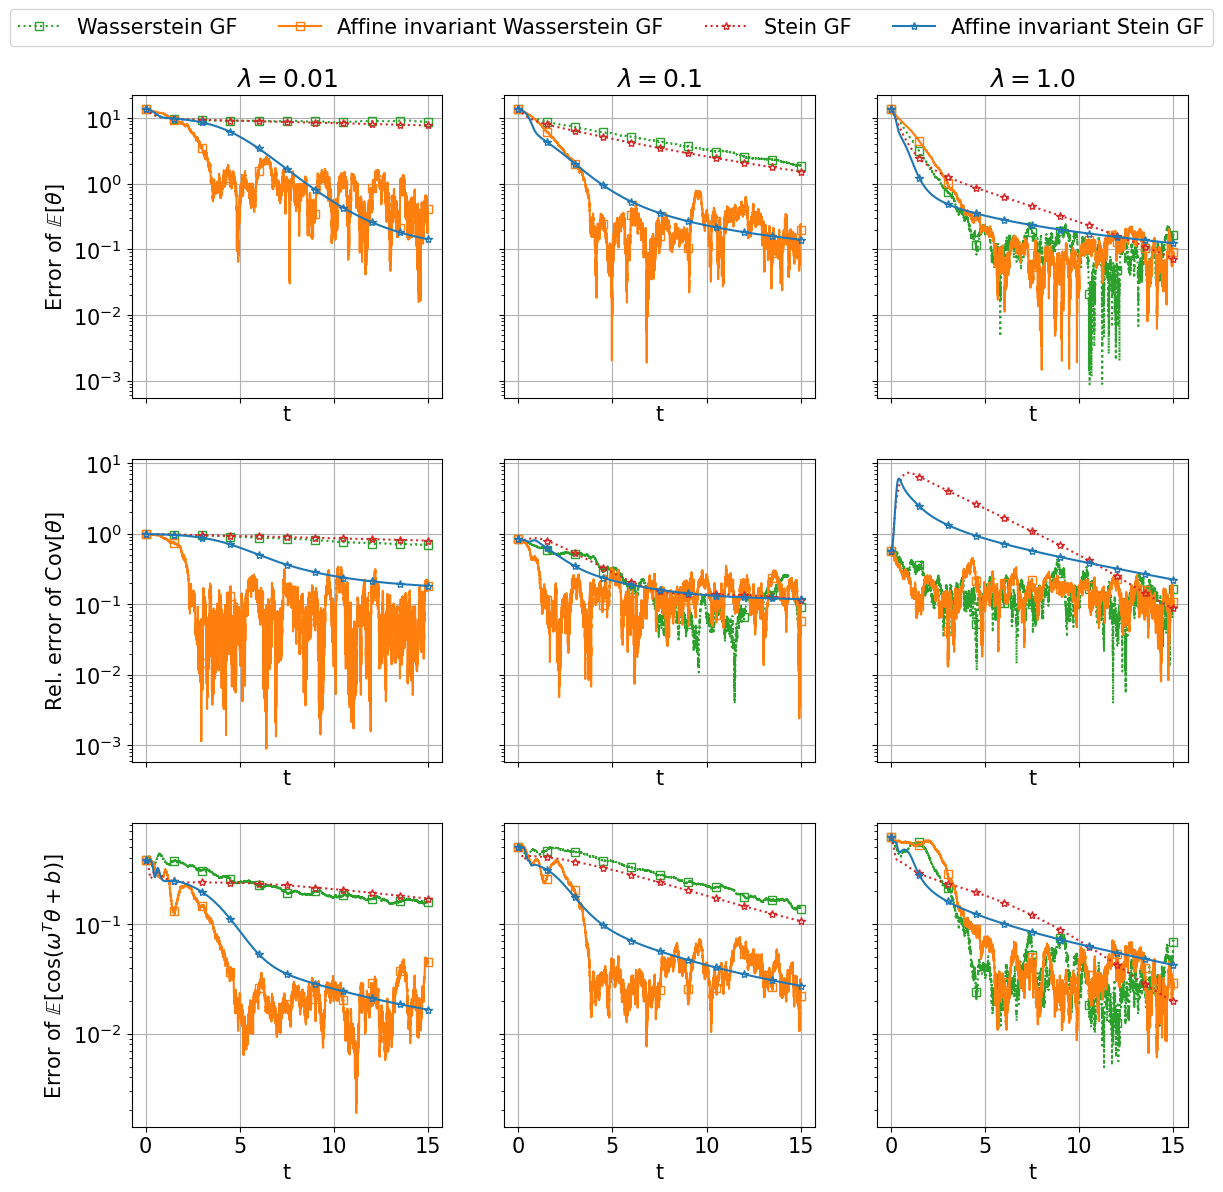

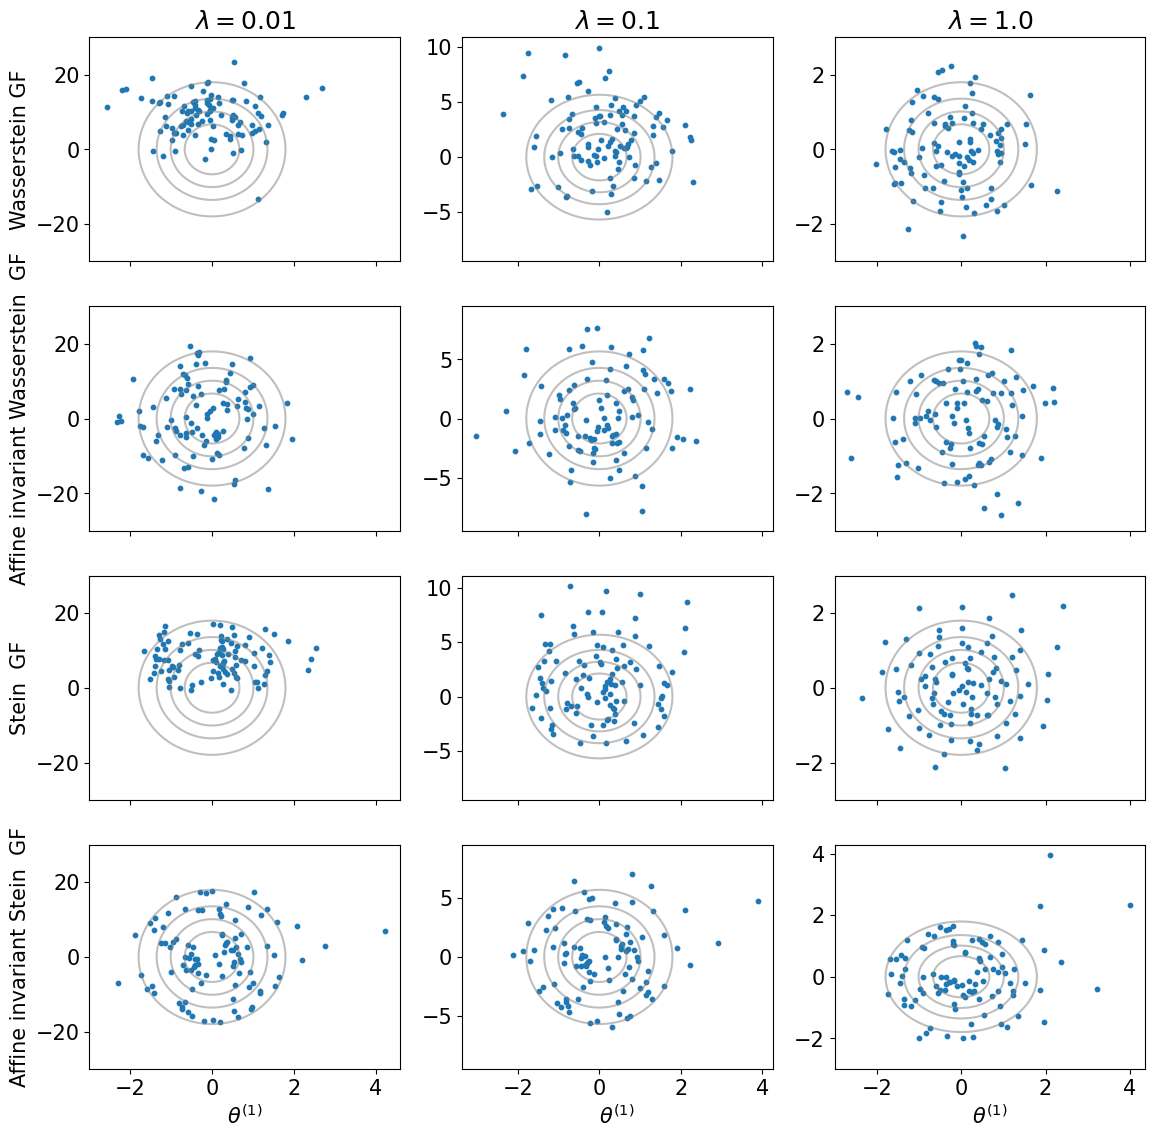

In [19]:
Random.seed!(42)
N_θ = 2
m_0 = [10.0; 10.0]
C_0 = [1/2 0; 0 2.0]

gradient_flow_for_sampling("Gaussian", m_0, C_0; λs = [0.01, 0.1, 1], N_ens = 100, Δt = 0.001, N_t = 15000)
   

## Gaussain approximated gradient flows

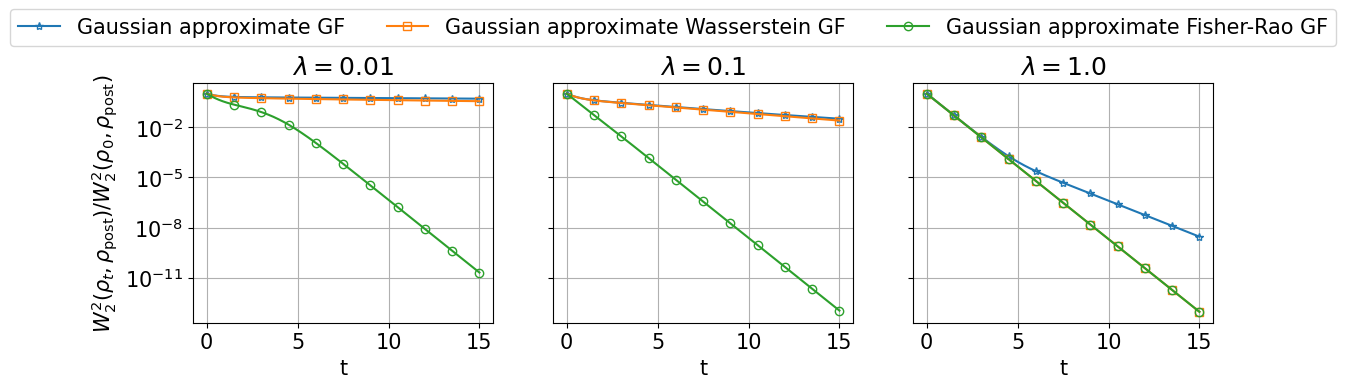

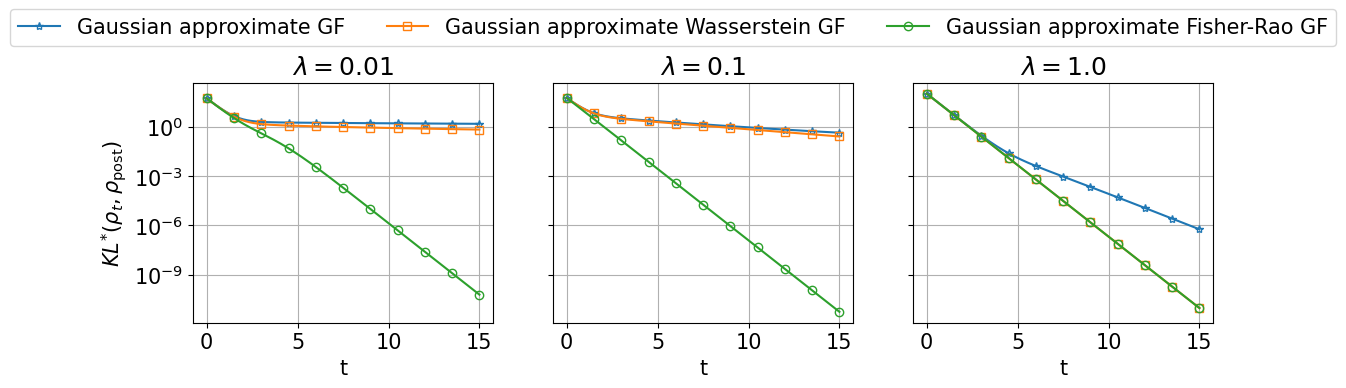

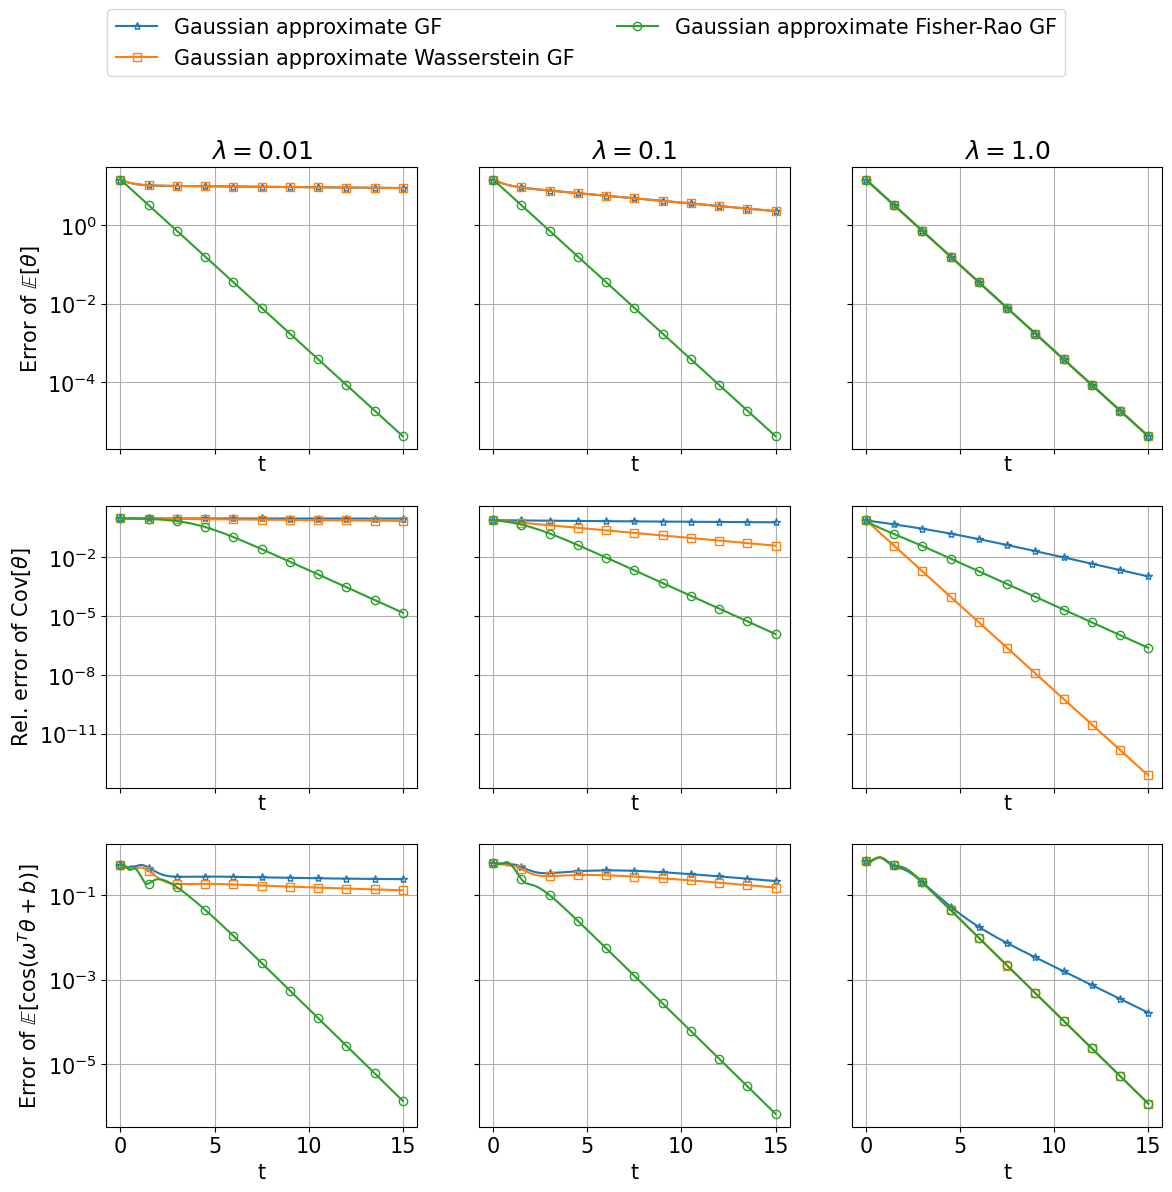

In [20]:
Random.seed!(42)
Δt, N_t = 1e-3, 15000
λs = [0.01, 0.1, 1]
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)

# initial condition
m_0 = [10.0; 10.0]
C_0 = [1/2 0; 0 2.0]

fig, ax = PyPlot.subplots(ncols=3, sharex=true, sharey=true, figsize=(12,4))
fig_err, ax_err = PyPlot.subplots(ncols=3, sharex=true, sharey=true, figsize=(12,4))
fig_conv, ax_conv = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))

for test_id = 1:length(λs)
    λ = λs[test_id]
    m_oo = [0; 0]
    C_oo = [1 0; 0 1/λ]

    m_gd, C_gd   = Continuous_Dynamics("gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_ngd, C_ngd = Continuous_Dynamics("natural_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_wgd, C_wgd = Continuous_Dynamics("wasserstein_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)


    e_gd, e_ngd, e_wgd = zeros(N_t+1),  zeros(N_t+1),  zeros(N_t+1)

    U,S,V = svd(C_oo)
    C_oo_sqrt = U*Diagonal(sqrt.(S))*V'

    for i = 1:N_t+1

        U,S,V = svd(C_oo_sqrt * C_gd[i,:,:] * C_oo_sqrt)
        e_gd[i]  = ( norm(m_gd[i,:] - m_oo)^2 + tr(C_gd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )

        U,S,V = svd(C_oo_sqrt * C_ngd[i,:,:] * C_oo_sqrt)
        e_ngd[i] = ( norm(m_ngd[i,:] - m_oo)^2 + tr(C_ngd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )

        U,S,V = svd(C_oo_sqrt * C_wgd[i,:,:] * C_oo_sqrt)
        e_wgd[i] = ( norm(m_wgd[i,:] - m_oo)^2 + tr(C_wgd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    e_gd  /= e_gd[1]
    e_ngd /= e_ngd[1]
    e_wgd /= e_wgd[1]
    
    ts = LinRange(0, Δt*N_t, N_t+1)
    
    ax[test_id].semilogy(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate GF")
    ax[test_id].semilogy(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Wasserstein GF")
    ax[test_id].semilogy(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Fisher-Rao GF")
    
    if test_id == 1  
        ax[test_id].set_ylabel(L" W^2_2(ρ_t , ρ_{\rm post}) / W^2_2(ρ_0 , ρ_{\rm post})")
    end
    
        
    ax[test_id].set_xlabel("t")
    ax[test_id].grid("on")
    ax[test_id].set_title(L"\lambda = " * string(λ))
    
    
    
    e_gd = zeros(N_t+1)
    e_wgd = zeros(N_t+1)
    e_ngd = zeros(N_t+1)
    for i = 1:N_t+1
        e_gd[i]  = KL_estimator(m_gd[i,:],  C_gd[i,:,:], m_oo, C_oo)  
        e_wgd[i] = KL_estimator(m_wgd[i,:], C_wgd[i,:,:], m_oo, C_oo)  
        e_ngd[i] = KL_estimator(m_ngd[i,:], C_ngd[i,:,:], m_oo, C_oo)  
    end
    ax_err[test_id].semilogy(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate GF")
    ax_err[test_id].semilogy(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Wasserstein GF")
    ax_err[test_id].semilogy(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Fisher-Rao GF")
    ax_err[test_id].set_title(L"\lambda = " * string(λs[test_id]))
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    
    cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 
    gd_errors    = zeros(N_t+1, 3)
    ngd_errors    = zeros(N_t+1, 3)
    wgd_errors    = zeros(N_t+1, 3)
    
    for i = 1:N_t+1
        m_i, C_i = m_gd[i,:], C_gd[i,:,:]
        gd_errors[i, 1]  = norm(m_i .- m_oo)
        gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_ngd[i,:], C_ngd[i,:,:]
        ngd_errors[i, 1]  = norm(m_i .- m_oo)
        ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_wgd[i,:], C_wgd[i,:,:]
        wgd_errors[i, 1]  = norm(m_i .- m_oo)
        wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
    end
    markevery=div(N_t, 10)
    ax_conv[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
            
    ax_conv[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax_conv[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax_conv[1, test_id].set_title(L"\lambda = " * string(λ))
    ax_conv[1, test_id].set_xlabel("t")
    ax_conv[2, test_id].set_xlabel("t")
    ax_conv[3, test_id].set_xlabel("t")
    
    ax_conv[1, test_id].grid("on")
    ax_conv[2, test_id].grid("on")
    ax_conv[3, test_id].grid("on")
end

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig.savefig("Gaussian_W2_gd_comp.pdf")


handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig_err.savefig("Gaussian_KL_gd_converge.pdf")


handles, labels = ax_conv[1,1].get_legend_handles_labels()
fig_conv.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
ax_conv[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax_conv[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax_conv[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig_conv.subplots_adjust(bottom=0.05,top=0.85,left=0.1,right=0.98,hspace=0.2)
fig_conv.savefig("Gaussian_gd_converge.pdf")



# Logconcave functions

## Gradient flows in the density function space 

┌ Info: ("Wasserstein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [9.633906816823883, 0.06154003359373898], " ", [0, 0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [40.340152741349144 0.12558465368572205; 0.12558465368572205 1.1916491237566826], " ", [1151.1533296101122 15.115332961011203; 15.115332961011203 1.5115332961011205])
└ @ Main In[16]:163
┌ Info: ("Wasserstein", " preconditioner ", true, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [-6.59285379818245, -0.04088133291007292], " ", [0, 0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [973.7810754863683 15.151230551966957; 15.151230551966957 1.392938030329489], " ", [1151.1533296101122 15.115332961011203; 15.115332961011203 1.5115332961011205])
└ @ Main In[16]:163
┌ Info: ("Stein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [9.769860250946564, 0.144895908744264], " ", [0, 0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [25.241408017501488 0.3859797346750131

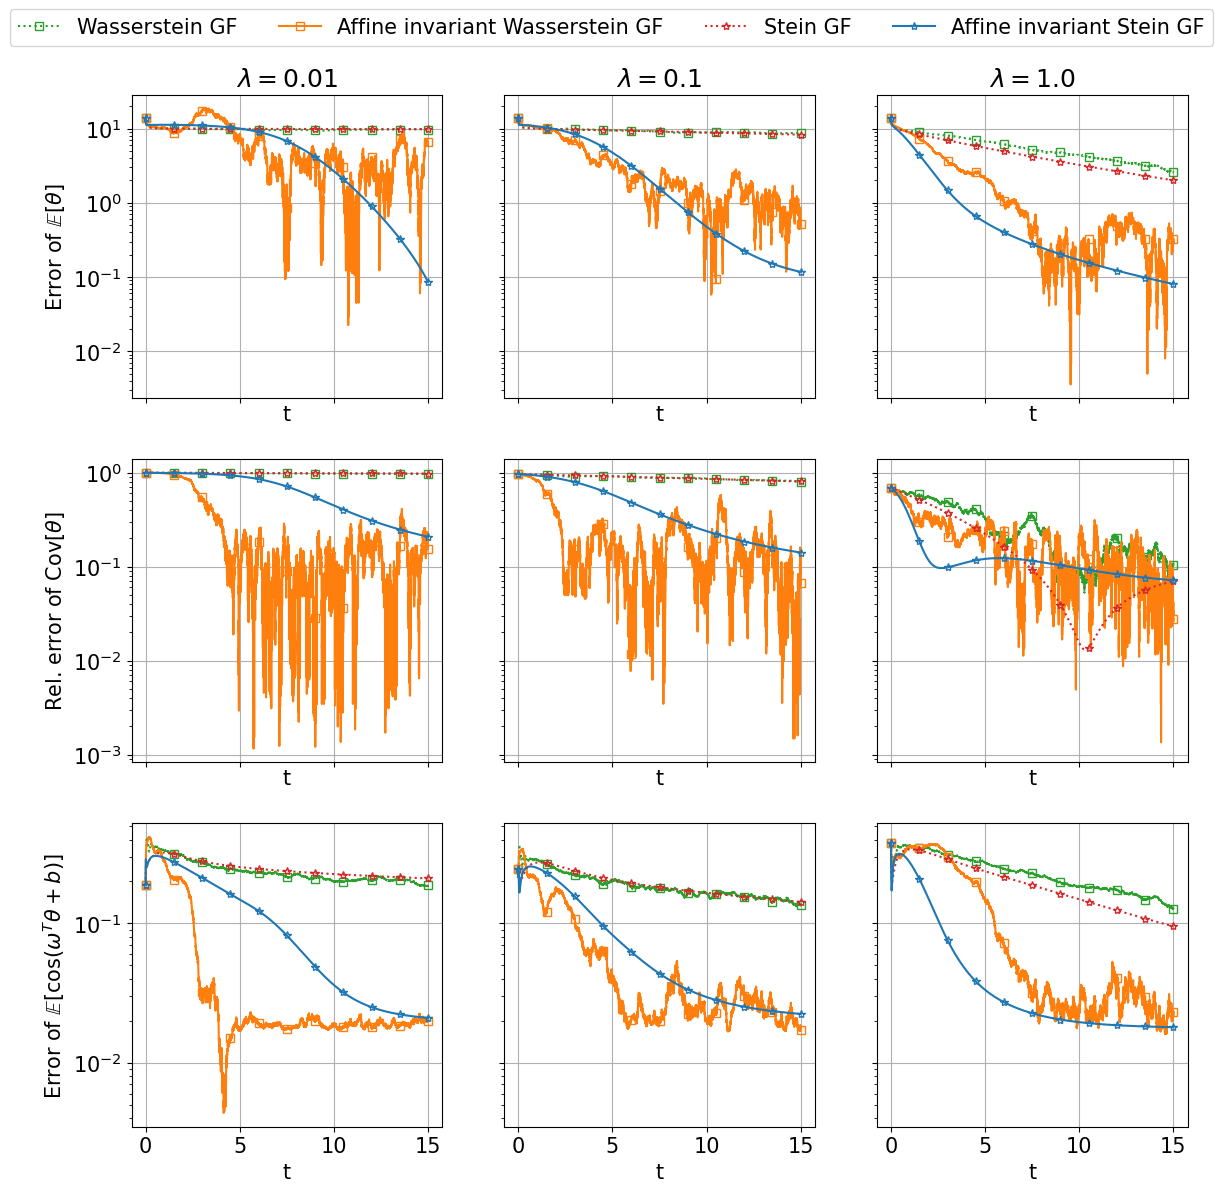

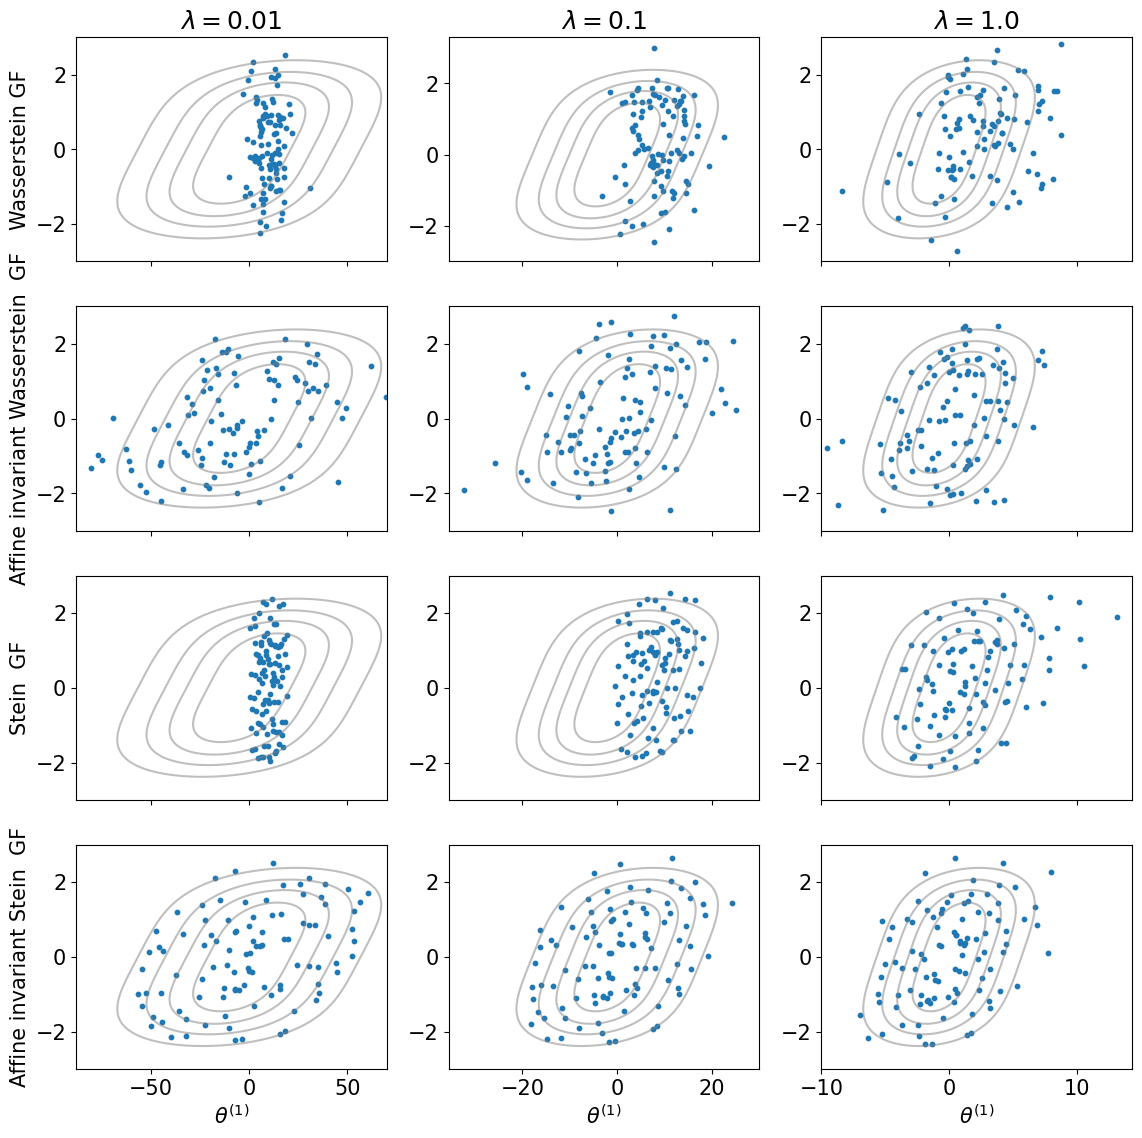

In [21]:
Random.seed!(42)
N_θ = 2
m_0 = [10.0; 10.0]
C_0 = [4.0 0; 0 4.0]


gradient_flow_for_sampling("Logconcave", m_0, C_0; λs = [0.01, 0.1, 1], N_ens = 100, Δt = 0.001, N_t = 15000)
   

## Gaussain approximated gradient flows

┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74


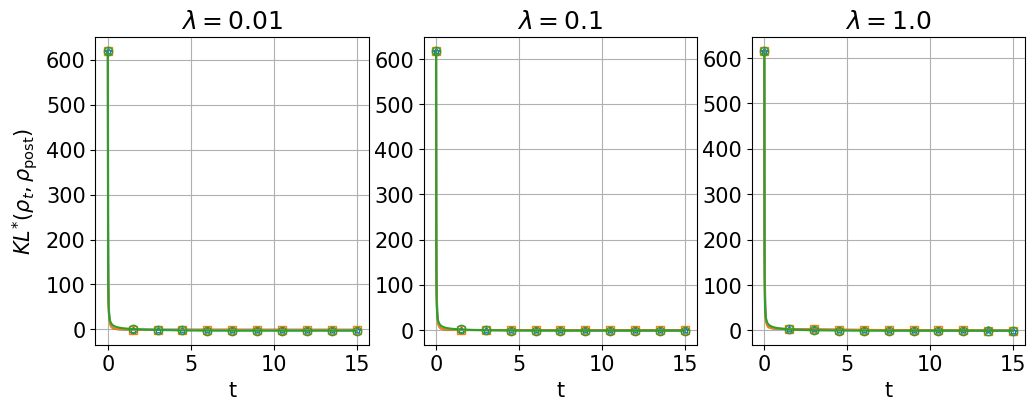

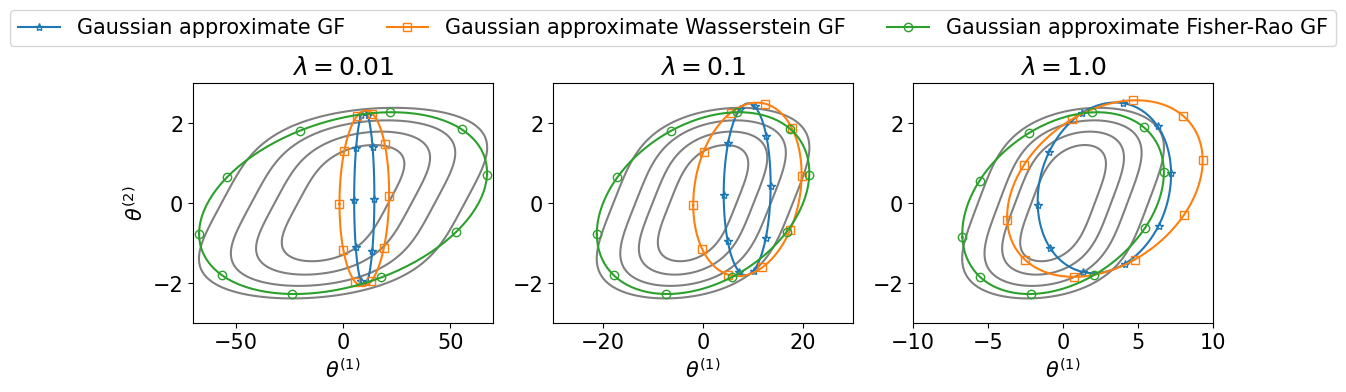

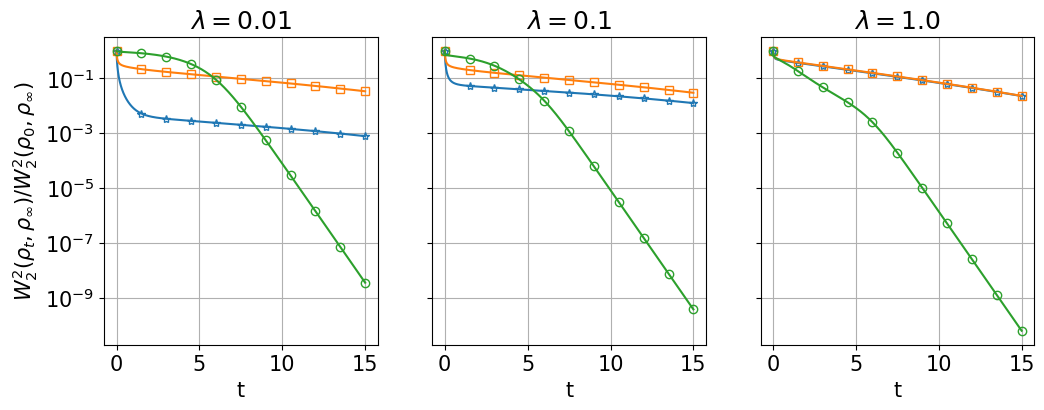

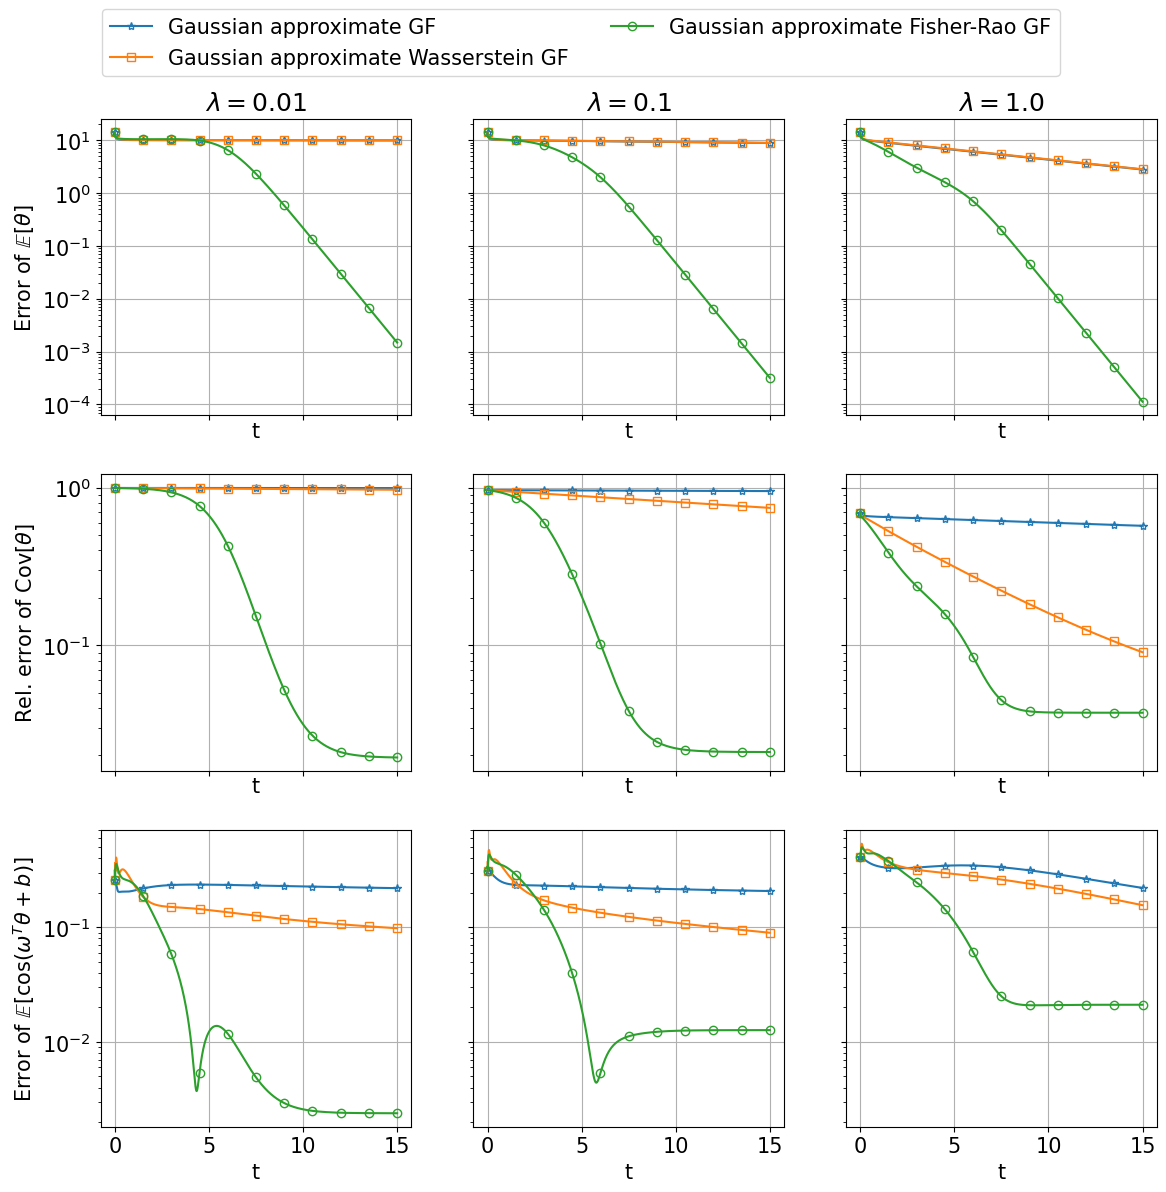

In [31]:
Random.seed!(42)
N_θ = 2
m_0 = [10.0; 10.0]
C_0 = [4.0 0; 0 4.0]
Gaussian_approximated_gradient_flow_for_sampling("Logconcave", m_0, C_0; λs = [0.01, 0.1, 1], Δt = 0.001, N_t = 15000, sampling_method = "UnscentedTransform", N_ens = 100)
 

# Rosenbrok

## Gradient flows in the density function space 

┌ Info: ("Wasserstein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [0.5741501409733789, 0.1510732706449068], " ", [1.0, 11.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [6.96423854302443 -0.6334149611582058; -0.6334149611582058 35.83800973441097], " ", [10.000000000000002 20.0; 20.0 1240.0])
└ @ Main In[16]:163
┌ Info: ("Wasserstein", " preconditioner ", true, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [0.42267515519505267, 9.708013248899249], " ", [1.0, 11.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [7.524730789343643 15.124360213735237; 15.124360213735237 920.9447315412104], " ", [10.000000000000002 20.0; 20.0 1240.0])
└ @ Main In[16]:163
┌ Info: ("Stein", " preconditioner ", false, " λ = ", 0.01)
└ @ Main In[16]:161
┌ Info: ("mean = ", [0.6133146676450556, -0.17908040002560316], " ", [1.0, 11.0])
└ @ Main In[16]:162
┌ Info: ("cov = ", [6.385866251289962 0.13829320796799133; 0.13829320796799133 21.097362333161133], " ", [10.0000000000000

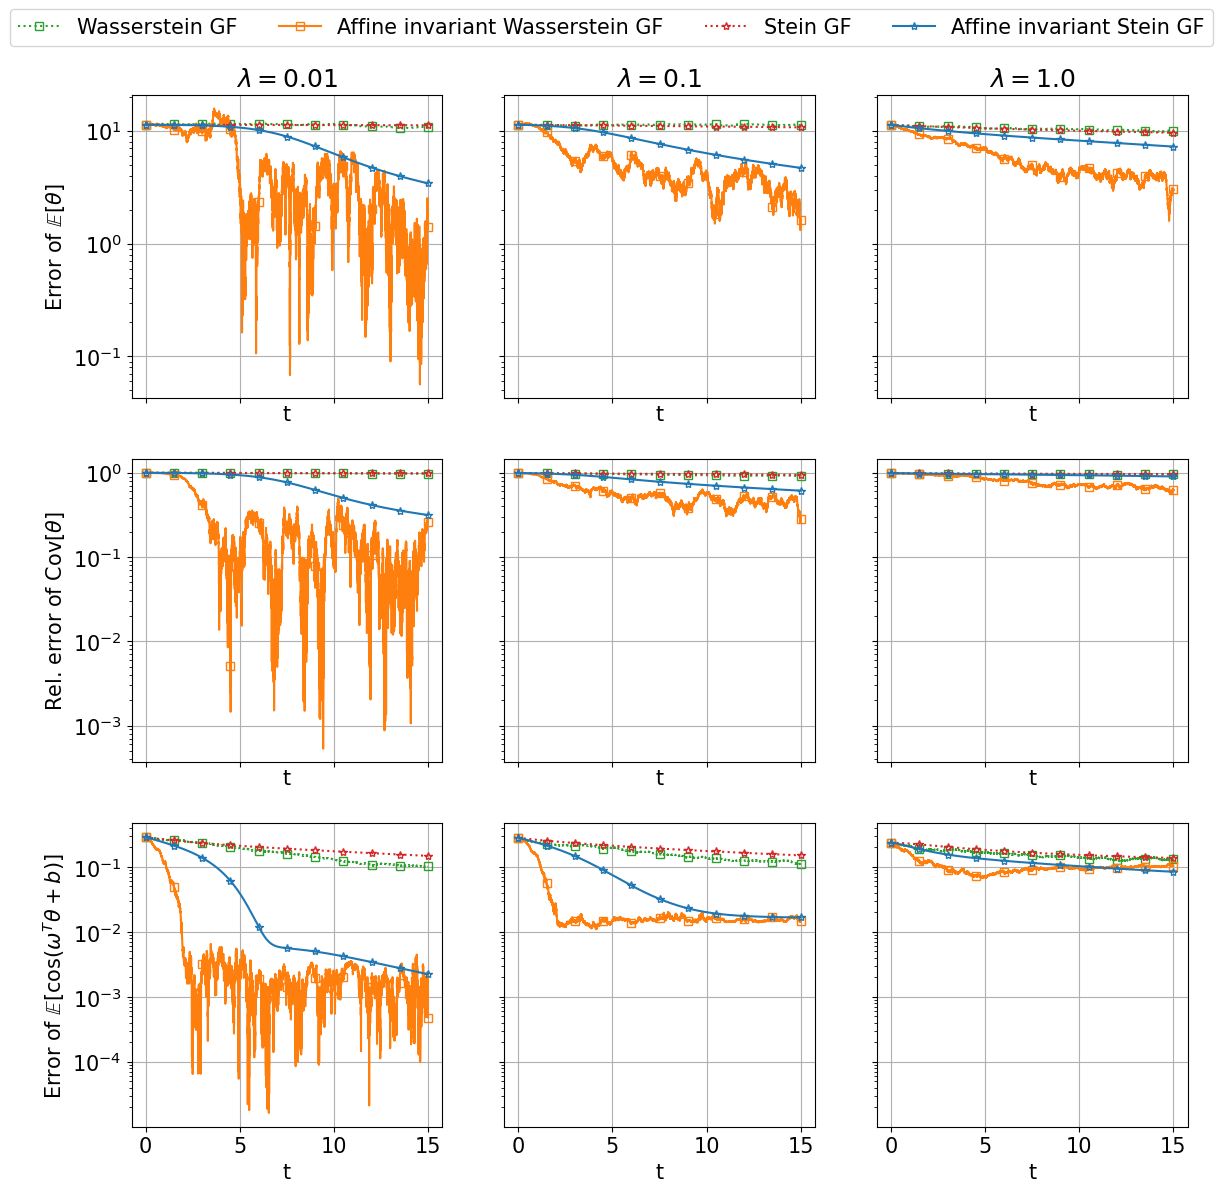

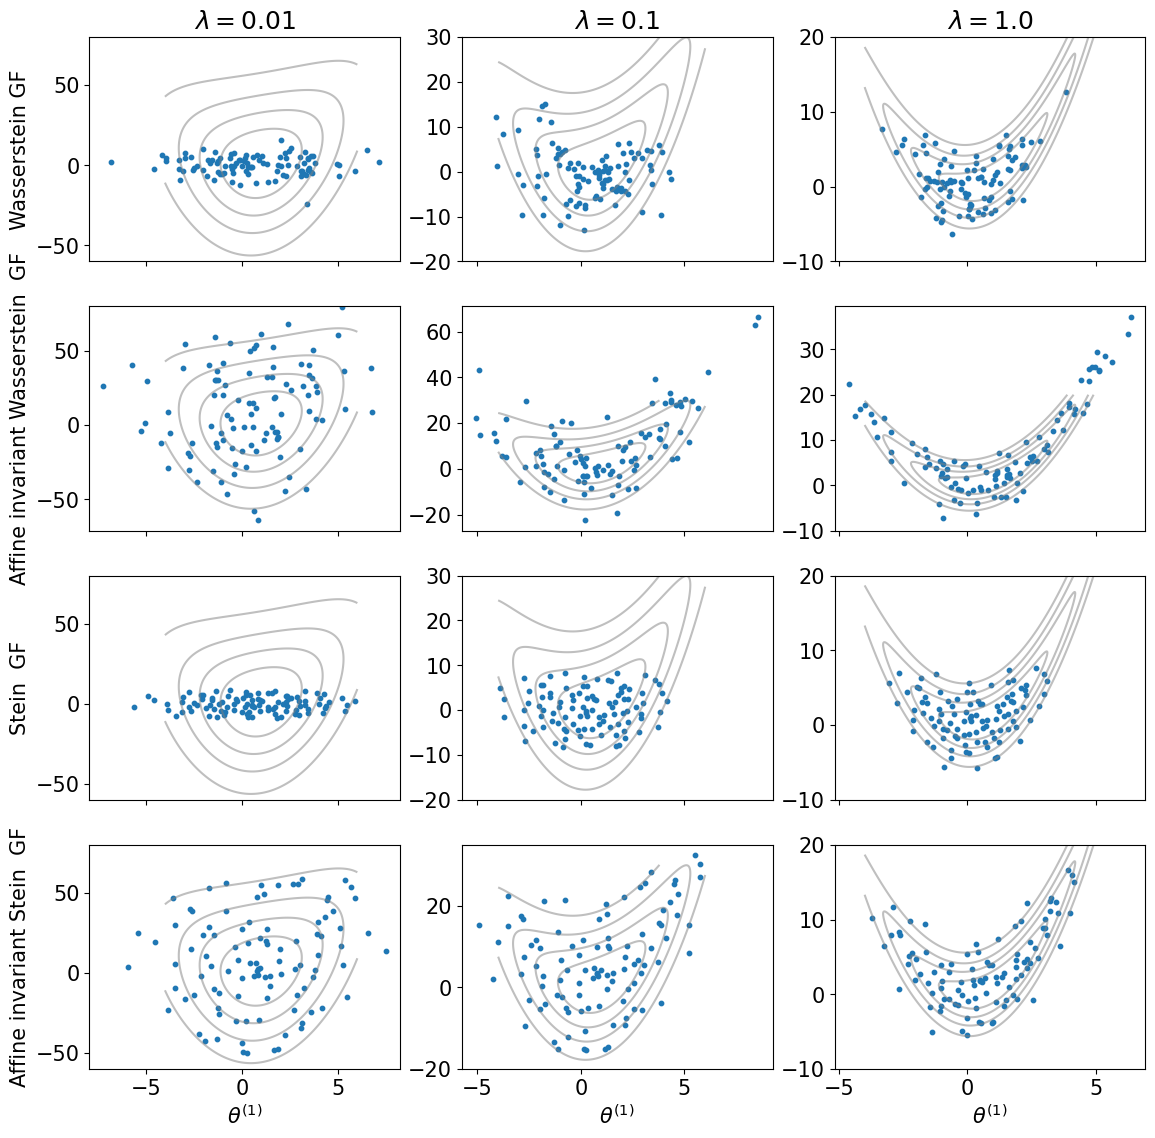

In [23]:
Random.seed!(42)
N_θ = 2
m_0 = [0.0; 0.0]
C_0 = [4.0 0; 0 4.0]
gradient_flow_for_sampling("Rosenbrock", m_0, C_0; λs = [0.01, 0.1, 1], N_ens = 100, Δt = 0.001, N_t = 15000)
   

## Gaussain approximated gradient flows

┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[30]:66
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[30]:70
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[30]:74


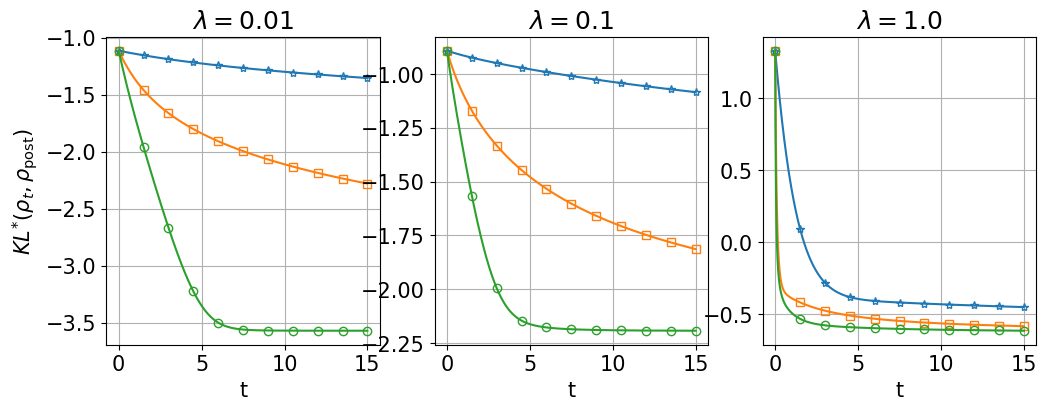

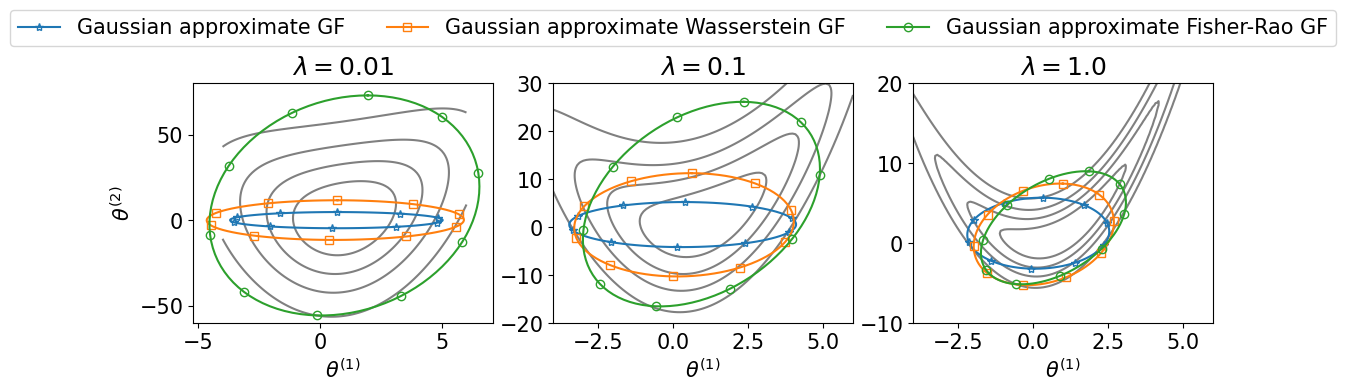

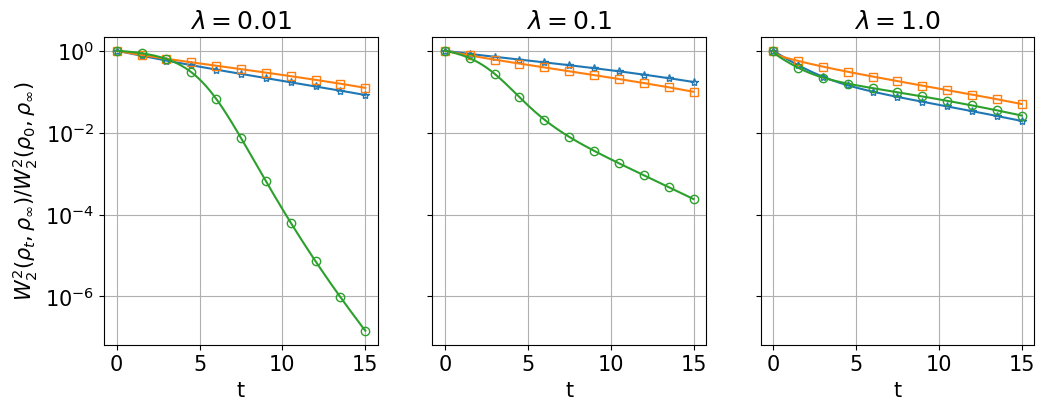

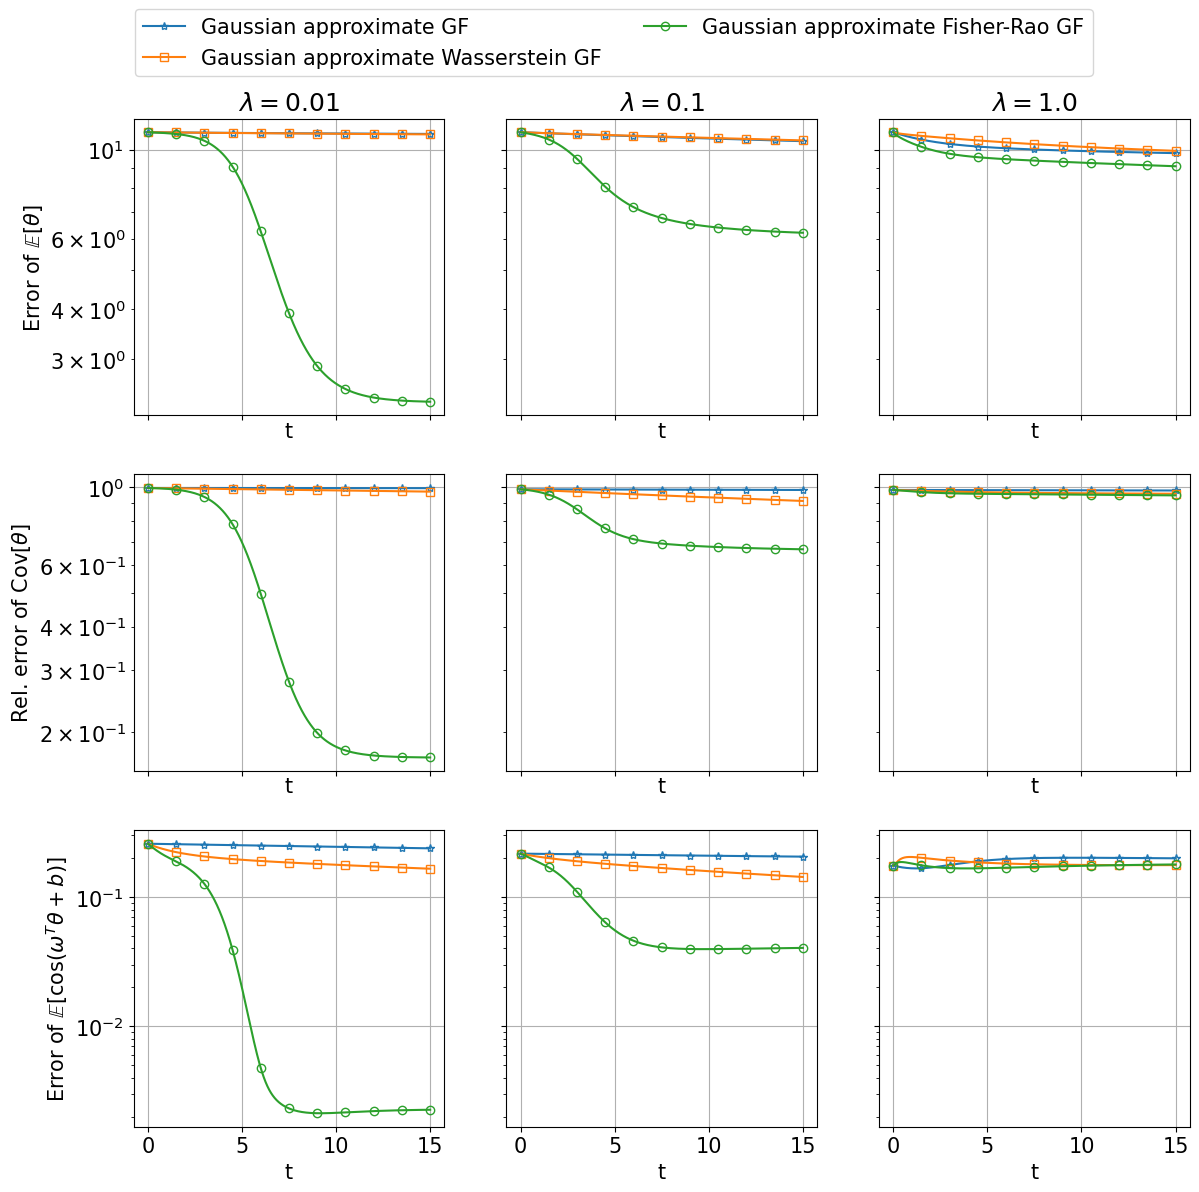

In [32]:
Random.seed!(42)
N_θ = 2
m_0 = [0.0; 0.0]
C_0 = [4.0 0; 0 4.0]

Gaussian_approximated_gradient_flow_for_sampling("Rosenbrock", m_0, C_0; λs = [0.01, 0.1, 1], Δt = 0.001, N_t = 15000, sampling_method = "UnscentedTransform", N_ens = 100)
 